In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Image Processing/23_IP_dataset')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls

carolus.ttf  Dictionary  image	resized_letter.png  temp.png


In [ ]:
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
import cv2
import numpy as np

font_path = 'carolus.ttf'
font_prop = FontProperties(fname=font_path, size=100)
character = 'k'

fig, ax = plt.subplots()
ax.text(0.5, 0.5, character, fontproperties=font_prop, ha='center', va='center', color='black')
ax.axis('off')
plt.savefig('temp.png', dpi=300, bbox_inches='tight', pad_inches=0)
plt.close(fig)

image = cv2.imread('temp.png', cv2.IMREAD_GRAYSCALE)

_, thresh = cv2.threshold(image, 1, 255, cv2.THRESH_BINARY_INV)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
x, y, w, h = cv2.boundingRect(contours[0])

target_size = 35
scale_factor = target_size / max(w, h)

resized = cv2.resize(image, (0,0), fx=scale_factor, fy=scale_factor)

cv2.imwrite('resized_letter.png', resized)

True

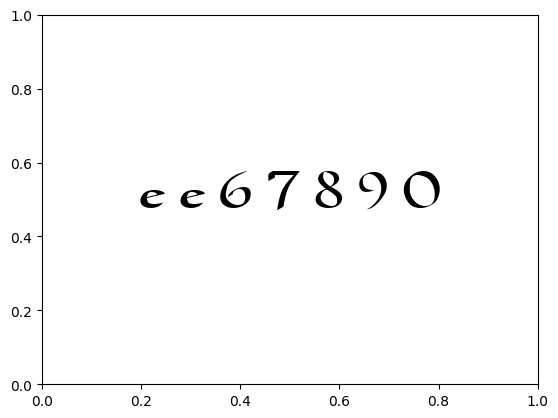

In [ ]:
font_path = 'carolus.ttf'
font_prop = FontProperties(fname=font_path, size=100)
fig, ax = plt.subplots()
ax.text(0.5, 0.5, 'e e 6 7 8 9 0', fontproperties=font_prop, ha='center', va='center', fontsize=45)
plt.show()

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
import cv2
import numpy as np
from skimage.morphology import dilation, square
# import pandas as pd

#Text Image Processing Section

## 1. Load the given image as a gray image. Mark the edges of the text box to correct the curved frame.
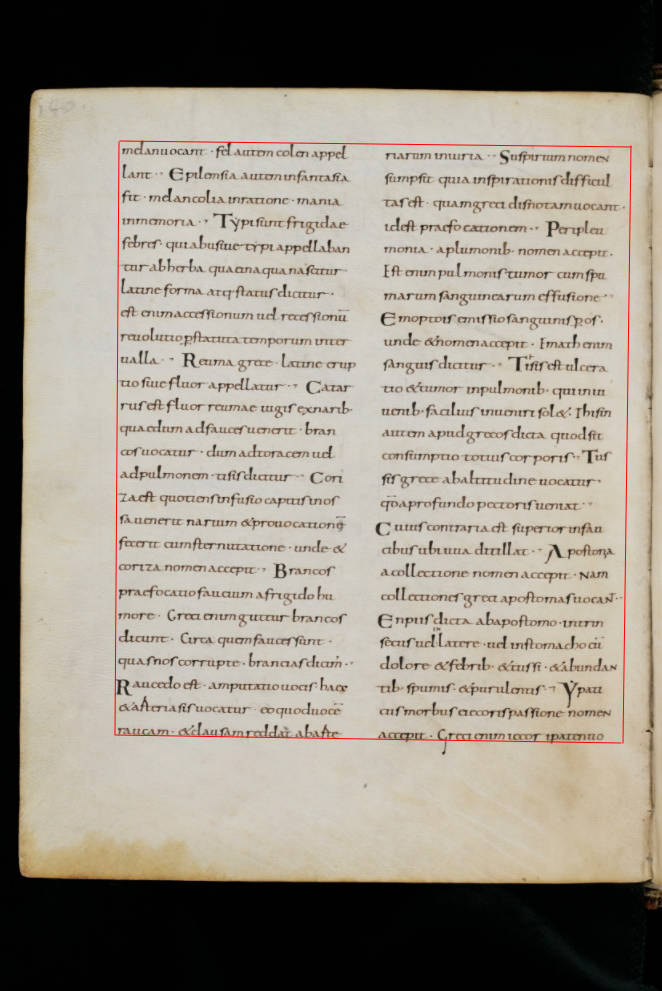

In [ ]:
def read_image(image_path):
  """
  Args:
    image_path(text): the path of the image
  Returns:
    image(np.array): ndarray of the image in gray
  """

  # Read the image using OpenCV
  image = cv2.imread(image_path)

  # Check if the image is loaded properly
  if image is None:
      raise ValueError("Image not found or the path is incorrect")

  return image

def find_corners(image):
  """
  Args:
    image(np.array): ndarray of the image in gray
  Returns:
    corners(np.array): corners in order [top left, top right, bottom right, bottom left]
  """
  # find edges
  low_threshold = 50
  high_threshold = 150
  edges = cv2.Canny(image, low_threshold, high_threshold)

  # highlight edges
  footprint = square(3)
  highlited_edges = dilation(edges, footprint)

  # find contours
  contours, _ = cv2.findContours(highlited_edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

  # find max contour
  max_contour = max(contours, key=cv2.contourArea)

  # find corners
  accuracy=0.1
  # Calculate the perimeter of the contour
  epsilon = accuracy * cv2.arcLength(max_contour, True)
  # Approximate the contour shape to another shape
  corners = cv2.approxPolyDP(max_contour, epsilon, True).squeeze()
  # to avoid errors
  if len(corners) != 4:
      corners = np.array([[0, 0],[0, 1],[1, 0],[1, 1]])

  # order corners
  # sort by y-coordinate
  corners = corners[np.argsort(corners[:, 1])]
  # find top two corners
  top_corners = corners[:2]
  top_corners = top_corners[np.argsort(top_corners[:, 0])]
  # find bottom two corners
  bottom_corners = corners[2:]
  bottom_corners = bottom_corners[np.argsort(bottom_corners[:, 0])]
  top_left, top_right, bottom_right, bottom_left = top_corners[0], top_corners[1], bottom_corners[1], bottom_corners[0]
  corners = np.array([top_left, top_right, bottom_right, bottom_left])

  return corners

def warp_image(image, corners):
  """
  Args:
    image(np.array): input image
    corners(np.array): corners in order [top left, top right, bottom right, bottom left]
  Returns:
    warped_image(np.array): warped with a perspective transform image of shape [H,W]
  """
  # H: max(lower-left-vertex_y - upper-left-vertex_y, lower-right-vertex_y - upper-right-vertex_y)
  # W: max(upper-right-vertex_x - upper-left-vertex_x, lower-right-vertex_x - lower-left-vertex_x).
  # Make sure that this vertex is placed on all four vertices of the new image, and then perform a deformation operation on the image.

  # top_left, top_right, bottom_right, bottom_left
  W = np.max([corners[1][0]-corners[0][0], corners[2][0]-corners[3][0]])
  H = np.max([corners[3][1]-corners[0][1], corners[2][1]-corners[1][1]])
  dst_points = np.array([[0, 0],[W-1, 0],[W-1, H-1],[0, H-1]], dtype=np.float32)

  # Compute the transformation matrix.
  M = cv2.getPerspectiveTransform(corners.astype(np.float32), dst_points)

  # Apply the perspective transformation.
  warped_image = cv2.warpPerspective(image, M, (W, H))

  return warped_image

def display_save(image, image_path, pre):

  # Display the image
  warped_image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.imshow(warped_image_rgb)
  plt.axis('off')  # Hide the axis
  plt.show()

  # Define the file path where the image will be saved
  path_parts = os.path.split(image_path)
  new_filename = pre + path_parts[1]
  save_path = os.path.join(path_parts[0], new_filename)

  # Save the image using cv2.imwrite
  cv2.imwrite(save_path, image)


## 2. Binarise and noise reduce the image.


In [ ]:
def gaussian_blur(image, sigma):
  """
  Args:
    image(np.array): input image
    sigma(float): standard deviation for Gaussian kernel
  Returns:
    blurred_image(np.array): 8-bit (with range [0,255]) blurred image
  """
  # Compute kernel size based on sigma. It's common to use 6 times sigma, rounded to the next odd integer.
  kernel_size = int(6*sigma + 1)
  # Ensure ksize is odd
  kernel_size = kernel_size + 1 if kernel_size % 2 == 0 else kernel_size

  blurred_image = cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)

  return blurred_image


def binarize(image, threshold_value):
  """
  Args:
    image(np.array): input image
    block_size(int): size of the neighbourhood area
    C(int): subtracted from the mean or weighted sum of the neighbourhood pixels
  return:
    binarized_image(np.array): binarized image, text is white and background is black

  https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html
  """
  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  _, binarized_image = cv2.threshold(gray_image, threshold_value, 255, cv2.THRESH_BINARY_INV)

  # CODE

  return binarized_image

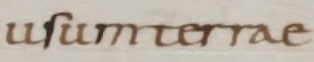

In [ ]:
def apply_affine_transform(template, angle):
    rows, cols = template.shape[:2]
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    return cv2.warpAffine(template, M, (cols, rows))

def template_matching(image, template_path):
    original_template = cv2.imread(template_path)
    h, w = original_template.shape[:2]

    scales = [1.0, 0.9, 1.1]
    angles = [0, 5, -5]

    matches = []

    image_result = image.copy()

    for scale in scales:
        for angle in angles:

            # padded_template = cv2.copyMakeBorder(original_template, 2, 2, 2, 0, cv2.BORDER_CONSTANT, value=[0, 0, 0])

            new_width = int(w * scale)
            new_height = int(h * scale)
            resized_template = cv2.resize(original_template, (new_width, new_height), interpolation=cv2.INTER_AREA)

            warped_template = apply_affine_transform(resized_template, angle)

            template_gray = cv2.cvtColor(warped_template, cv2.COLOR_BGR2GRAY)

            plt.imshow(cv2.cvtColor(template_gray, cv2.COLOR_BGR2RGB))
            plt.title("template")
            plt.show()

            method = cv2.TM_CCOEFF_NORMED
            threshold = 0.8

            while True:
                res = cv2.matchTemplate(image_result, template_gray, method)
                min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

                if max_val > threshold:
                    top_left = max_loc
                    bottom_right = (top_left[0] + new_width, top_left[1] + new_height)

                    match_part = image[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]
                    matches.append(match_part)
                    plt.imshow(cv2.cvtColor(match_part, cv2.COLOR_BGR2RGB))
                    plt.title("match_part")
                    plt.show()

                    image_result[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]] = 0
                else:
                    break

    return matches, image_result

In [ ]:
def match_loop(templates, result_image):
  for template_name in templates:
    if template_name != 'None':
      print('template_name: ', template_name)

      path_to_template = './Dictionary/' + template_name
      matches, result_image = template_matching(result_image, path_to_template)
      print(len(matches))

      pre = 'afterMatch_'
      display_save(result_image, image_path, pre)

      # Check if the folder exists, if not, create it
      folder_path = './Dictionary/' + template_name[:-6]
      if not os.path.exists(folder_path):
          os.makedirs(folder_path)

      # Save each match to the specified path
      save_path = folder_path + '/' + template_name[:-6]
      for i in range(len(matches)):
          save_path_to_image = f"{save_path}_{i+2}.png"
          print(save_path_to_image)
          cv2.imwrite(save_path_to_image, matches[i])

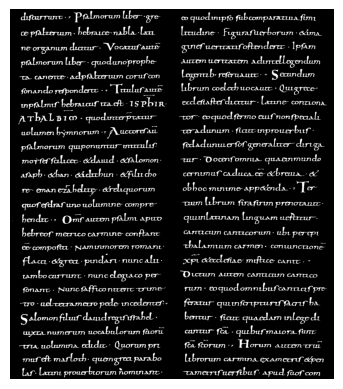

NameError: ignored

In [ ]:
# Load the image
image_path = './image/e-codices_csg-0231_184_max.jpg'
image = read_image(image_path)

# With red frame
marked_image_path = './image/page_2_marked.png'
marked_image = read_image(marked_image_path)

# Find corners
corners = find_corners(marked_image)

# Warp image
warped_image = warp_image(image, corners)

# Display and save
# pre = 'warped_'
# display_save(warped_image, image_path, pre)

# Binary
binarized_image = binarize(warped_image, threshold_value = 170)

pre = 'binarized_'
display_save(binarized_image, image_path, pre)

csv_path = './Dictionary/dictionary.csv'
data = pd.read_csv(csv_path)
templates = data.iloc[:, 1].tolist()
print(templates)
# i should be the last one to be found
# n should be after m
# small letter first, then the longer and larger one.
templates = ['y_1.png', 'z_1.png', 'b_1.png', 'c_1.png', 'd_1.png', 'e_1.png', 'f_1.png', 'g_1.png', 'h_1.png', 'l_1.png', 'm_1.png', 'n_1.png', 'o_1.png', 'p_1.png', 'q_1.png', 'r_1.png', 's_1.png', 't_1.png', 'u_1.png', 'x_1.png', 'u_1.png', 'i_1.png']

We do template matching here to get multiple letter images.

In [ ]:
# result_image = binarized_image
# match_loop(templates, result_image)

Missing letters being added here, using carolus.ttf and example images.

In [ ]:
# Add missing letters
missing = False
if missing:
  source_folder = './Dictionary/ori'
  target_folder = './Dictionary/missing'
  os.makedirs(target_folder, exist_ok=True)
  for filename in os.listdir(source_folder):
      if filename.endswith('.png'):
          image_path = os.path.join(source_folder, filename)
          image = cv2.imread(image_path)
          processed_image = binarize(image, threshold_value=170)
          cv2.imwrite(os.path.join(target_folder, filename), processed_image)

Generate sentence

In [ ]:
from PIL import Image, ImageFilter
import os
import random
import numpy as np

# sentence generator below
def load_images_for_sentence(sentence, image_dir):
    images = []
    collecting = False
    collected_chars = ""
    for char in sentence:
        # justify if it is like (christi)
        if collecting:
          if char == ')':
            collecting = False
            collected_chars += char

            image_path = os.path.join(image_dir, f"{collected_chars}.png")
            try:
              character_image = Image.open(image_path)
              images.append((collected_chars, character_image))
            except IOError:

              print(f"Image for {collected_chars} not found.")

            collected_chars = ""
          else:
            collected_chars += char
          continue

        if char == '(':
          collecting = True
          collected_chars += char
          continue

        if char != ' ':

          # small letter
          if char in ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'v', 'x', 'y', 'z', 'j', 'u', 'w']:
            image_path = os.path.join(image_dir, f"{char}_1.png")
            try:
              character_image = Image.open(image_path)
              images.append((char, character_image))
            except IOError:
              print(f"Image for {char} not found.")

          # notation
          elif char in ['.', ',', ';']:
            image_path = os.path.join(image_dir, f"{char}_notation.png")
            try:
              character_image = Image.open(image_path)
              images.append((char, character_image))
            except IOError:
              print(f"Image for {char} not found.")

          # number
          elif char in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']:
            image_path = os.path.join(image_dir, f"{char}_number.png")
            try:
              character_image = Image.open(image_path)
              images.append((char, character_image))
            except IOError:
              print(f"Image for {char} not found.")

          # upper letter
          else:
            image_path = os.path.join(image_dir, f"{char}_c_1.png")
            try:
              character_image = Image.open(image_path)
              images.append((char, character_image))
            except IOError:
              print(f"Image for {char} not found.")

        else:
          images.append((' ', None))

    return images

# when consider the distance between each letter, we need to justify both in total width and letter pasting
def calculate_size(loaded_images):
    total_width = 0
    max_height = 0
    letter_spaces = []
    word_spaces = []
    for char, image in loaded_images:
        if image:
            letter_spacing = random.randint(2, 3)
            right_offset = calculate_right_offset(char)
            total_width += image.size[0] + right_offset + letter_spacing
            max_height = max(max_height, image.size[1])
            letter_spaces.append(letter_spacing)
        else:
            word_spacing= random.randint(30, 50)
            total_width += word_spacing
            word_spaces.append(word_spacing)

    return total_width, max_height+34, letter_spaces, word_spaces

def transform_image(image):

    # make it blur
    blur_radius = random.uniform(0.9, 1)
    image = image.filter(ImageFilter.GaussianBlur(blur_radius))

    rotation_angle = random.uniform(-2, 2)
    rotated_image = image.rotate(rotation_angle, expand=True)

    scale_factor = random.uniform(0.98, 1.02)
    new_width = int(rotated_image.width * scale_factor)
    new_height = int(rotated_image.height * scale_factor)

    vertical_stretch_factor = random.uniform(0.98, 1.02)
    stretched_height = int(new_height * vertical_stretch_factor)

    transformed_image = rotated_image.resize((new_width, stretched_height), Image.ANTIALIAS)

    return transformed_image

def create_final_image(loaded_images, total_width, max_height, letter_spaces, word_spaces):
    final_image = Image.new('RGB', (total_width, max_height), (0, 0, 0))
    current_width = 0
    letter_position = []
    letter_space_index = 0
    word_space_index = 0

    for char, image in loaded_images:
        letter_position.append(current_width)
        if image:
            image = transform_image(image)
            bottom_offset = calculate_bottom_offset(char)
            right_offset = calculate_right_offset(char)
            final_image.paste(image, (current_width, max_height - image.size[1] + bottom_offset))
            current_width += image.size[0] + right_offset + letter_spaces[letter_space_index]
            letter_space_index += 1
        else:
            current_width += word_spaces[word_space_index]
            word_space_index += 1

    return final_image, letter_position

def calculate_bottom_offset(char):
    bottom_offsets = {'f': -19, 'g': 0, 'p': -14, 'q': -14, 'j': -3, 'F': -13,
                              'G': -23, 'H': -31, 'J': -6, 'P': -20, 'Q': -22, 'R': -22,
                              'T': -31, 'Y': 0, 'Z': -30,
                              '(christi)': -28, '(prae)': -16, '(que)': -14, '(em)': -34, '(am)': -34, '(et)': -34,}
    return bottom_offsets.get(char, -34)

def calculate_right_offset(char):
    right_offsets = {'f': -20}
    # , 'g': 0, 'p': -14, 'q': -14, 'j': -3, 'F': -13,' G': -23, 'H': -31, 'J': -6, 'P': -20, 'Q': -22, 'R': -22, 'T': -31, 'Y': 0, 'Z': -30
    return right_offsets.get(char, 0)

def make_black_transparent(image, shift_white_letter):

    img = image
    img = img.convert("RGBA")
    data = np.array(img)

    red, green, blue, alpha = data[:,:,0], data[:,:,1], data[:,:,2], data[:,:,3]
    dark_mask = (red < 100) & (green < 100) & (blue < 100)
    data[:,:,:4][dark_mask] = [0, 0, 0, 0]

    if shift_white_letter:
      # Invert bright pixels (RGB > 100)
      bright_mask = (red > 100) & (green > 100) & (blue > 100)
      data[:,:,0][bright_mask] = 255 - data[:,:,0][bright_mask]
      data[:,:,1][bright_mask] = 255 - data[:,:,1][bright_mask]
      data[:,:,2][bright_mask] = 255 - data[:,:,2][bright_mask]

    new_img = Image.fromarray(data)

    return new_img

In [ ]:
# demo
image_dir = './Dictionary'

# Put your latin sentence here:
sentence = "nomenq genusql"
# Hope our work will help more people. - Spero opus nostrum iuvabit magis populus
sentence = "Spero opus nostrum iuvabit magis populus."
#(christi); 1234567890 (prae),  (et). fafefsft.
sentence = "qkqk(christi)(prae), (et)fafefsft. 1a2b3c4d5f67890"

loaded_images = load_images_for_sentence(sentence, image_dir)
total_width, max_height, letter_spaces, word_spaces = calculate_size(loaded_images)
final_image, letter_position = create_final_image(loaded_images, total_width, max_height, letter_spaces, word_spaces)
# final_image = make_black_transparent(final_image, shift_white_letter=True) # choose shift white letter to black or not
final_image_path = os.path.join(image_dir, "final_sentence_image.png")
final_image.save(final_image_path)
print("Image created and saved to", final_image_path)

Image created and saved to ./Dictionary/final_sentence_image.png


<ipython-input-28-bb9c5fc8b0bf>:115: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  transformed_image = rotated_image.resize((new_width, stretched_height), Image.ANTIALIAS)


## 6. Get image of individual letters, record their center points and width and height in a csv table.

In [ ]:
def get_letters_masks(image, kernel_size):
  """
  Args:
    image(np.array): input image
    kernel_size(int): the size of erosion/ dilation kernel
  Returns:
    letters_masks(np.array): a list of individual letters masks
  """

  # CODE

  return letters_masks


def detect_letters(letters_mask):
  """
  Args:
    letters_mask(np.array): an individual letters mask
  Returns:
    x_min(int): the minimum x-coordinate value of the bounding box
    x_max(int): the maximum x-coordinate value of the bounding box
    y_min(int): the minimum y-coordinate value of the bounding box
    y_max(int): the maximum y-coordinate value of the bounding box
  """

  # CODE

  return x_min, x_max, y_min, y_max


def crop_letters(letters_mask, x_min, x_max, y_min, y_max)
  """
  Args:
    letters_mask(np.array): an individual letters mask
    x_min(int): the minimum x-coordinate value of the bounding box
    x_max(int): the maximum x-coordinate value of the bounding box
    y_min(int): the minimum y-coordinate value of the bounding box
    y_max(int): the maximum y-coordinate value of the bounding box
  Returns:
    croped_letters(np.array): a croped letters mask, the mask shape is the same as the bounding box
  """

  # CODE

  return croped_letters


def position_info(x_min, x_max, y_min, y_max)
  """
  Args:
    x_min(int): the minimum x-coordinate value of the bounding box
    x_max(int): the maximum x-coordinate value of the bounding box
    y_min(int): the minimum y-coordinate value of the bounding box
    y_max(int): the maximum y-coordinate value of the bounding box
  Returns:
    center_point(nd.array): the coordinates of the center point
    H(int): the height of the bounding box
    W(int): the width of the bounding box
  """

  # CODE

  return center_point, H, W


def detect_letters(letters_masks, dir):
  """
  Args:
    letters_masks(np.array): a list of individual letters masks
    dir(text): a folder path for saving the letters files
  Outputs:
    000_letters.png
    001_letters.png
    ...
    letters_info.csv: image path - cernter point x - center point y - H - W
  """

  # code


#Font Processing Section

## 1. Read letter pictures list.



In [ ]:
def read_letters(dir):
  """
  Args:
    dir(text): a folder path saving the letters files
  Returns:
    letters_list(np.array): a list of letter pictures matrixes
  """

  # CODE

  return letters_list

## 2. Spread the letter pictures directly into feature vectors.

In [ ]:
def to_feature(letters_list):
  """
  Args:
    letters_list(np.array): a list of letter pictures matrixes
  Returns:
    letters_feature_list(np.array): a 2-dimentional ndarray, every row is a feature of letter
  """

  # CODE

  return letters_feature_list



##3. Use clustering algorithms such as K-Means to classify the category of each letter picture, i.e., which letter it corresponds to; and then manually screen it to exclude classification errors caused by some errors. Calculate the probability that each letter corresponds to the occurrence of a different writing form.

In [ ]:
def kmeans(letters_feature_list, n_clusters):
  """
  Args:
    letters_feature_list(np.array): a 2-dimentional ndarray, every row is a feature of letter
    n_clusters(int): the number of clusters in the algorithm kmeans
  Returns:
    kmeans(Kmeans instance):
  """

  # CODE

  return kmeans


def add_category(kmeans, dir):
  """
  Args:
    kmeans(Kmeans instance)
    dir(text): the folder path saving the letters information table
  Output:
    update the "letters" in the letters information table
  """

  # CODE


def clusters_list(kmeans):
  """
  Args:
    kmeans(Kmeans instance)
  Returns:
    clusters_list(np.array): a list of the index of the letters closest to the cluster centers
  """

  # CODE

  return clusters_list

# Line Alignment and Spacing Between Letters

## 1. Detect the position of every line

In [ ]:
def detect_lines_pos(image):
  """
  Args:
    image(np.array): input image
  Returns:
    lines_pos_x(np.array): a list of the border of lines in x-axis
    lines_pos_y(np.array): a list of the border of lines in y-axis
  """

  # CODE

  return lines_pos_x, lines_pos_y


def lines_bounding_boxes(lines_pos_x, lines_pos_y):
  """
  Args:
    lines_pos_x(np.array): a list of the border of lines in x-axis
    lines_pos_y(np.array): a list of the border of lines in y-axis
  Returns:
    lines_bounding_boxes(np.array): a list of bounding boxes of lines, in shape [n,2,4]. N rows, 2 columns, 4: x_max,x_min,y_max,y_min
  """

  # CODE

  return lines_bounding_boxes


def add_line_belonging(lines_bounding_boxes, dir):
  """
  Args:
    lines_bounding_boxes(np.array): a list of bounding boxes of lines, in shape [n,2,4]. N rows, 2 columns, 4: x_max,x_min,y_max,y_min
    dir(text): the folder path saving the letters information table
  Output:
    update the "line" in the letters information table
  """

  # CODE



## 2. Statistics of the vertical coordinates of the lowest pixel of all the letters in each line, take the median of about five so as to filter out such as "f", "g" and other letters with tails, and then take the average value, to get the position of the baseline.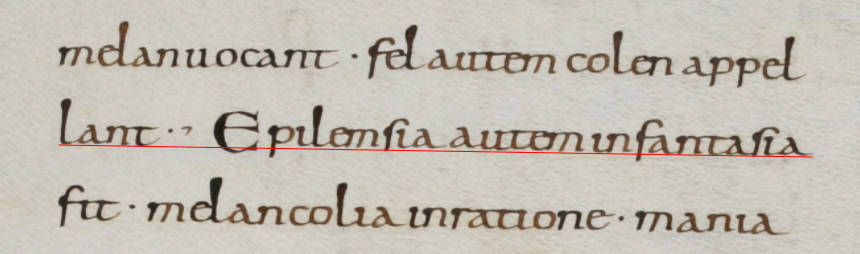

In [ ]:
def get_baseline_pos(dir):
  """
  Args:
    dir(text): the folder path saving the letters information table
  Returns:
    baseline_pos_list(np.array): a list of the y coordinate of every row
  """

  # CODE

  return baseline_pos_list

## 3. Calculate the vertical coordinates of all the letters in this line minus the value of the baseline vertical coordinate, and store it in the alphabet dictionary.
The advantage of this is that some "f "s have tails and some don't, so this can take into account the fact that there are more than one way to write a letter.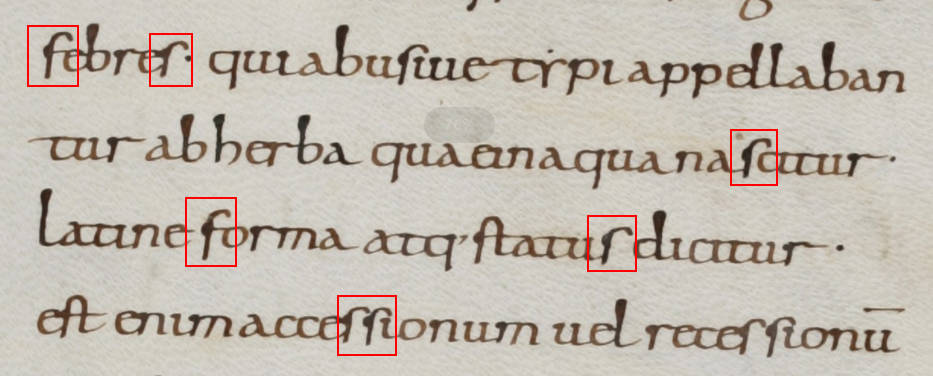

In [ ]:
def add_baseline_dis(baseline_pos_list, dir):
  """
  Args:
    baseline_pos_list(np.array): a list of the y coordinate of every row
    dir(text): the folder path saving the letters information table
  Outputs:
    update the "baseline distance" in the letters information table. The relative distance between the letter and the baseline
  """

  # CODE



## 4. Create a new dictionary to store the distance between two letters.

In [ ]:
def avg_distance(letter1. letter2):
  """
  Args:
    dir(text): the folder path saving the letters information table
    letter1(text): the letter in front
    letter2(text): the letter behind
  Returns:
    avg_distance(int): the average x-axis distance between two letters
  """

  # CODE

  return avg_distance


def get_distance_matrix(dir):
  """
  Args:
    dir(text): the folder path saving the letters information table
  Returns:
    distance_matrix(np.array): a matrix of distances between two letters
  """

  # CODE

  return distance_matrix

## 5. For spaces, we set a blanking threshold, if the distance between two letters (relative distance minus one-half of the width of each letter) exceeds this threshold, it is judged as a space, and the distance between the two letters is not recorded; for spaces of different lengths, we count the lengths of multiple spaces and the frequency of their occurrence, and randomly select them when generating them.
2 is space but not 1.
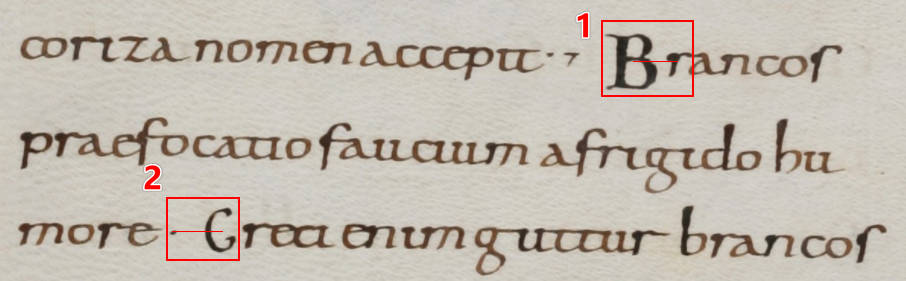

# Creat text image for a line

## 1. Read the text, create a new canvas, find the handwritten letters corresponding to the text one by one, and generate them randomly according to probability. Determine the distance of the next handwritten letter based on the distance between the letter pairs. Generate the handwritten font at the new location again according to the probability. Finally return the generated image matrix (np.array). There is a limit to the length of the input text, too much will report an error.

In [ ]:
class LineGenerator:
  def __init__(self, dir):
    self.dir = dir
    self.letters_locations = []
    self.letters_font = []

  def set_text(text):
    self.text = text

  def generate_font():
    # generate randon font

    self.letters_font = letters_font

  def get_letters_locations(self):
    """
    Returns:
      letters_distances(huinp.array): a list of locations of letters (including spaces)
    """

    # CODE

    return letters_locations

  def get_words_locations(self):
    """
    Returns:
      words_locations(np.array): a list of locations of words
    """

    # CODE

    return words_locations

  def get_line_mask(self):
    """
    Returns:
      line_mask(np.array): a mask image of input text
    """

    # CODE

    return line_mask, beseline_location

# **构建字体库数据**
* 读入图像

## 图像预处理
* 图像灰度化
* 四角变形
* 图像去噪
* 图像阈值化

## 获取字符基础数据
* 图像腐蚀
* 提取连通域
* 连通域膨胀获得独立字符mask
* 获取独立字符定位
* 裁剪独立字符mask至贴合
* 计算并记录中心点坐标和宽高
* 计算并记录独立字符左边界与前一字符右边界的x距离之差
* 计算并记录独立字符中心点与baseline的y距离之差

## 获取字符手写形态多样性矩阵
* 使用kmeans算法对某字符x对应的所有独立字符mask进行分析
* 聚类中心数量为n，取分别距离聚类中心最近的n个字符形态作为字符x的代表手写形态
* 根据kmeans的分类结果计算某一分类的频率，并用频率估计该分类对应的手写形态的概率

## 获取字符两两间距取值范围矩阵
* 统计某字符y在字符x前的情况下的字符间距取值范围，构造矩阵

# **根据输入文本生成手写字符mask以及相关定位信息**

## 确定字符的手写形态
* 遍历输入的文本，根据字符手写形态多样性矩阵中的概率随机选取每个输入字母对应的手写字符mask

## 生成字符定位
* 遍历输入的文本，
* 对于首字母，字符左边界为0，右边界为w
* 对于空格，空格距离为某一确定范围内的随机值
* 对于一般情况，在字符两两间距取值范围矩阵中查找距离范围，在范围内取随机值进而计算左边界位置，右边界为左边界+w

## 生成单词定位
* 根据字符定位生成单词定位

## 生成输入文本的手写字符mask
* 根据前面计算的字符定位对独立的手写字符mask进行叠加
* 对生成的mask进行贴合裁剪并计算出baseline的相对位置

# **输入和输出**

## 输入
* 古籍书页图片
* ground truth 文件里的 line position, baseline position, word, word position

## 输出
* 字符定位
* 单词定位
* 手写字符的mask，以及mask里baseline的相对定位（y轴坐标）